### Imports

In [50]:
from tqdm import tqdm
import random
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_mtsim
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/")
from gym_mtsim_forked.gym_mtsim.data import FOREX_DATA_PATH_TRAIN, FOREX_DATA_PATH_TEST, FOREX_DATA_PATH, STOCKS_DATA_PATH, FOREX_DATA_PATH_PRODUCTION, FOREX_DATA_PATH_1HR
from gym_mtsim import OrderType, Timeframe, MtEnv, MtSimulator
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, STATUS_FAIL
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from datetime import datetime, timedelta
import time
import torch
import pickle
import fx_rl

# Parameters

In [3]:

# unpack the pickle file and load the data that is in symbols_forex.pkl
with open(FOREX_DATA_PATH, 'rb') as f:
    symbols = pickle.load(f)
# convert symbols to a pd.dataframe
# symbols[1]['EURUSD']

In [4]:
# get the 2 weeks of the symbols[1]['EURUSD'] dataframe by first finding the max date
# then subtracting 14 days from that date
symbols[1]['EURUSD'].index = pd.to_datetime(symbols[1]['EURUSD'].index)
max_date = symbols[1]['EURUSD'].index.max()

In [4]:
# find the previous friday before max_date
# what is the day of the week of the max_date
max_day_of_week = max_date.dayofweek
# subtract the day of the week from the max_date to get the previous friday
if max_day_of_week >= 4:
    max_friday = max_date
else:
    max_friday = max_date - pd.DateOffset(days=max_day_of_week+2)
two_weeks = max_friday - pd.DateOffset(days=14)
one_week = max_friday - pd.DateOffset(days=7)

In [5]:
training_index_slice = symbols[1]['EURUSD'].loc[:one_week, :].index
validation_index_slice = symbols[1]['EURUSD'].loc[one_week:max_friday, :].index

In [6]:
validation_index_slice

DatetimeIndex(['2024-05-06 00:00:00+00:00', '2024-05-06 01:00:00+00:00',
               '2024-05-06 02:00:00+00:00', '2024-05-06 03:00:00+00:00',
               '2024-05-06 04:00:00+00:00', '2024-05-06 05:00:00+00:00',
               '2024-05-06 06:00:00+00:00', '2024-05-06 07:00:00+00:00',
               '2024-05-06 08:00:00+00:00', '2024-05-06 09:00:00+00:00',
               ...
               '2024-05-10 14:00:00+00:00', '2024-05-10 15:00:00+00:00',
               '2024-05-10 16:00:00+00:00', '2024-05-10 17:00:00+00:00',
               '2024-05-10 18:00:00+00:00', '2024-05-10 19:00:00+00:00',
               '2024-05-10 20:00:00+00:00', '2024-05-10 21:00:00+00:00',
               '2024-05-10 22:00:00+00:00', '2024-05-10 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Time', length=120, freq=None)

### Create Env

In [7]:
class MyMtEnv(gym_mtsim.MtEnv):
    # _get_modified_volume = fx_rl.my_get_modified_volume
    _get_prices = fx_rl.my_get_prices

In [8]:
sim_train = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

In [9]:
env_train = MyMtEnv(
    original_simulator=sim_train,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(training_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [10]:
sim_validation = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_validation = MyMtEnv(
    original_simulator=sim_validation,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(validation_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [11]:
sim_validation_2 = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_validation_2 = MyMtEnv(
    original_simulator=sim_validation_2,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(validation_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

### Define Functions

In [77]:
def print_stats(reward_over_episodes, printing_name):
    """  Print Reward  """

    avg_rewards = np.mean(reward_over_episodes)
    min_rewards = np.min(reward_over_episodes)
    max_rewards = np.max(reward_over_episodes)

    print (f'Min. {printing_name}          : {min_rewards:>10.3f}')
    print (f'Avg. {printing_name}          : {avg_rewards:>10.3f}')
    print (f'Max. {printing_name}          : {max_rewards:>10.3f}')

    return min_rewards, avg_rewards, max_rewards

def my_profit_calculation(env_orders, stop_loss):
        # env_orders = env_testing.render()['orders']
        # stop_loss = 0.001
        mean_value = env_orders['Volume'].mean()

        # # Normalize the column to have a mean of 1
        env_orders.loc[:, 'Volume'] = round((env_orders['Volume'] / mean_value), 2)
        # add a column for when the difference between the Entry Price and the Exit Price is greater than stop_loss
        env_orders.loc[:, 'stoploss_hit'] = np.where((env_orders['Type'].str.strip() == 'Buy') &
                                                        ((env_orders['Entry Price'] - env_orders['Exit Price']) > stop_loss),
                                                        1, np.where((env_orders['Type'].str.strip() == 'Sell') &
                                                                        ((env_orders['Exit Price'] - env_orders['Entry Price']) > stop_loss),
                                                                        1, 0))
        env_orders.loc[:, 'Exit Price'] = np.where((env_orders['Type'].str.strip() == 'Buy') & (env_orders['stoploss_hit'] == 1),
                                                        env_orders['Entry Price'] - stop_loss,
                                                        np.where((env_orders['Type'].str.strip() == 'Sell') & (env_orders['stoploss_hit'] == 1),
                                                                env_orders['Entry Price'] + stop_loss, env_orders['Exit Price']))
        env_orders.loc[:, 'Profit'] = np.where((env_orders['Type'].str.strip() == 'Buy'),
                                                        ((env_orders['Exit Price'] - (env_orders['Fee']/2)) - 
                                                        (env_orders['Entry Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume'], 
                                                        np.where((env_orders['Type'].str.strip() == 'Sell'),
                                                                ((env_orders['Entry Price'] - (env_orders['Fee']/2)) - 
                                                                (env_orders['Exit Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume'], np.nan))
        total_reward = env_orders.loc[:, 'Profit'].sum()
        # Calculate Gross Profit
        gross_profit = env_orders.loc[env_orders['Profit'] > 0, 'Profit'].sum()

        # Calculate Gross Loss
        gross_loss = env_orders.loc[env_orders['Profit'] < 0, 'Profit'].abs().sum()

        # Calculate Profit Factor
        profit_factor = gross_profit / gross_loss if gross_loss != 0 else 0

        profit_factor = profit_factor - 1

        return profit_factor, total_reward

# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


In [78]:
# TRAINING + TEST
def train_val_model(model, model_policy, env_tr, env_val, seed, steps_str, lr, gamma_param, entropy, total_learning_timesteps=10_000):
    """
    Trains and validates a model using the Proximal Policy Optimization (PPO) algorithm.

    Args:
        model (object): The model to be trained.
        model_policy (object): The policy used by the model.
        env_tr (object): The training environment.
        env_val (object): The validation environment.
        seed (int): The random seed for reproducibility.
        steps_str (str): A string representing the number of steps.
        window_size_param (int): The window size parameter.
        lr (float): The learning rate.
        gamma_param (float): The gamma parameter.
        entropy (float): The entropy coefficient.
        total_learning_timesteps (int, optional): The total number of learning timesteps. Defaults to 10,000.

    Returns:
        tuple: A tuple containing the reward over validations, orders over validations, and the model dictionary.
    """
    # reproduce training and test
    print('-' * 80)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    #model_dict = {}
    # env_tr.window_size = window_size_param
    print(f'entropy: {entropy}, learning rate: {lr}, gamma: {gamma_param}')
    # eval_callback = EvalCallback(env_tr, log_path='./logs/', eval_freq=1000)
    model = PPO(model_policy, env_tr, verbose=0, ent_coef=entropy, learning_rate=lr)#, gamma=gamma_param, 
    obs_tr, info_tr = env_tr.reset(seed=seed)
    # custom callback for 'progress_bar'
    model.learn(total_timesteps=total_learning_timesteps)#, callback=ProgressBarCallback(100))

    reward_over_validations = []
    orders_over_validations = []
    profit_over_validations = []

    for episode in range(0, 10):
        obs_val, info_val = env_val.reset(seed=seed)

        total_reward = 0
        done_val = False

        while not done_val:
            action, _states = model.predict(obs_val)
            obs_val, reward_val, terminated_val, truncated_val, info_val = env_val.step(action)
            done_val = terminated_val or truncated_val

            total_reward += reward_val
            if done_val:
                break
        try:
            orders_made_in_episode = env_val.render()['orders']
            order_len = len(orders_made_in_episode)
            total_reward, total_profit = my_profit_calculation(orders_made_in_episode, 0.001)
            
        except Exception as e:
            print('There were not any orders produced by the model')
            print(f'Here is the error {e}')
            order_len = 0
            total_profit = 0

        # model_dict[f'model_{episode}'] = model
        # model.save(f'best_hyperparameters/models_4_26_24/model_{episode}.pkl')

        reward_over_validations.append(total_reward) 
        profit_over_validations.append(total_profit)   
        orders_over_validations.append(order_len)  


        # if episode % 1 == 0:
        avg_reward = np.mean(reward_over_validations)
        avg_orders = np.mean(orders_over_validations)
        avg_profit = np.mean(profit_over_validations)
        print(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}, # of orders: {avg_orders:.3f}, avg Profit: {avg_profit:.3f}')
    model.save(f'models_{max_date.date()}/model_{steps_str}_{max_date.date()}.pkl')
    return reward_over_validations, orders_over_validations, profit_over_validations#, model_dict

## Objective Function

In [79]:
seed = 2024  # random seed
total_num_episodes = 10

# print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# learning_timesteps_list_in_K = [25]#, 50, 100]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html

timesteps_models_dict = {}
def objective(params):
    learning_timesteps = 100 #params['learning_timesteps']
    ent_coef = params['ent_coef']
    gamma = params['gamma'] #0.99 #
    learning_rate = params['learning_rate']#0.0003#

    if learning_rate > 0.08:
        print(f'Learning rate too high: {learning_rate}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    if ent_coef > 0.1:
        print(f'Entropy too high: {ent_coef}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}

    total_learning_timesteps = learning_timesteps * 1000
    step_key = f'{learning_timesteps}K'
    policy_dict = PPO.policy_aliases
    policy = policy_dict.get('MultiInputPolicy')
    class_name = type(PPO).__qualname__
    plot_key = f'{class_name}_rewards_'+step_key
    try:
        rewards, orders, profits = train_val_model(PPO, policy, env_train, env_validation, seed, step_key,  
                                                    learning_rate, gamma, ent_coef, total_learning_timesteps)
    except Exception as e:
        print(f'''there was an error {e} with those parameters: timesteps: {learning_timesteps}, \n
              ent_coef: {ent_coef}, gamma: {gamma}, learning_rate: {learning_rate}''')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    # timesteps_models_dict[step_key] = models_dict
    min_rewards, avg_rewards, max_rewards, = print_stats(rewards, 'Reward')
    print_stats(orders, 'Orders')
    label = f'Avg. {avg_rewards:>7.2f} : {class_name} - {step_key}'
    plot_data[plot_key] = rewards
    plot_settings[plot_key] = {'label': label}
    params['avg_orders'] = np.mean(orders)
    params['profits'] = np.mean(profits)       

    return {'loss': -avg_rewards, 'status': STATUS_OK, 'eval_time': time.time(), 'parameters': params} 

seed                     : 2024


In [15]:
# best_hyperparameters_current_week = pd.read_excel('best_hyperparameter_search_results.xlsx')

In [16]:
trials_latest_week = pickle.load(open(f'gym_mtsim_forked/examples/hyperopt/trials_5_11_search_next_week copy.pkl', 'rb'))
trials_latest_week_all_results = trials_latest_week.results
print(len(trials_latest_week_all_results),
trials_latest_week_all_results[0])

154 {'loss': 0.2156048802707855, 'status': 'ok', 'eval_time': 1715473469.2543254, 'parameters': {'ent_coef': 0.009472480156303364, 'gamma': 0.9736700301735044, 'learning_rate': 0.022388054169556464, 'avg_orders': 34.7, 'profits': -206.43268134863837}}


In [17]:
trials_latest_week.best_trial

{'state': 2,
 'tid': 72,
 'spec': None,
 'result': {'loss': -9.075780196707433,
  'status': 'ok',
  'eval_time': 1715487428.5866513,
  'parameters': {'ent_coef': 0.02658672176098117,
   'gamma': 0.9384834999422831,
   'learning_rate': 0.0013422065651556886,
   'avg_orders': 8.3,
   'profits': 12.813945444509761}},
 'misc': {'tid': 72,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'ent_coef': [72], 'gamma': [72], 'learning_rate': [72]},
  'vals': {'ent_coef': [0.02658672176098117],
   'gamma': [0.9384834999422831],
   'learning_rate': [0.0013422065651556886]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2024, 5, 12, 4, 13, 44, 668000),
 'refresh_time': datetime.datetime(2024, 5, 12, 4, 17, 8, 586000)}

In [18]:
best_hyperparameters_current_week = pd.DataFrame()
new_dict = {}
for idx, result in enumerate(trials_latest_week_all_results):
    new_dict['loss'] = result['loss']
    new_dict['status'] = result['status']
    new_dict['learning_rate'] = result['parameters']['learning_rate']
    new_dict['ent_coef'] = result['parameters']['ent_coef']
    new_dict['gamma'] = result['parameters']['gamma']
    try:
        new_dict['orders'] = result['parameters']['avg_orders']
        new_dict['profits'] = result['parameters']['profits']
    except Exception as e: 
        new_dict['orders'] = 0
        new_dict['profits'] = 0
    new_row = pd.DataFrame(new_dict, index=[idx])
    best_hyperparameters_current_week = pd.concat([best_hyperparameters_current_week, new_row], axis=0)
best_hyperparameters_current_week


,loss,status,learning_rate,ent_coef,gamma,orders,profits
0,0.215605,ok,0.022388,0.009472,0.973670,34.7,-206.432681
1,0.225823,ok,0.019788,0.001261,0.954884,35.1,-218.620373
2,0.249505,ok,0.017339,0.013237,0.957291,35.7,-276.932802
3,0.171849,ok,0.036101,0.027270,0.940642,34.3,-169.978201
4,0.928362,ok,0.016114,0.014936,0.950037,1.5,-37.811666
...,...,...,...,...,...,...,...
149,0.287532,ok,0.000962,0.027253,0.941019,56.8,-494.427835
150,0.259503,ok,0.006787,0.039203,0.942367,49.0,-353.817181
151,0.245509,ok,0.000081,0.036173,0.940280,49.5,-364.747439
152,-0.062589,ok,0.003499,0.032757,0.931431,50.6,-39.815564


In [19]:
best_hyperparameters_current_week_success = best_hyperparameters_current_week[best_hyperparameters_current_week['status'] == 'ok']
best_hyperparameters_current_week_success_negative = best_hyperparameters_current_week_success[best_hyperparameters_current_week_success['loss'] < 0]
best_hyperparameters_current_week_success_negative = best_hyperparameters_current_week_success_negative.sort_values(by='loss', ascending=True)
best_hyperparameters_current_week_success_negative

,loss,status,learning_rate,ent_coef,gamma,orders,profits
72,-9.075780,ok,0.001342,0.026587,0.938483,8.3,12.813945
144,-3.851724,ok,0.001990,0.030629,0.939654,5.6,80.505641
138,-1.057583,ok,0.000632,0.009179,0.934755,6.9,12.657717
64,-0.881712,ok,0.004026,0.021398,0.946325,10.1,-60.280493
116,-0.489285,ok,0.013312,0.010920,0.956157,34.4,94.959732
46,-0.392924,ok,0.008094,0.028483,0.955911,23.2,-32.423003
74,-0.376067,ok,0.001245,0.014424,0.933852,8.3,-54.139175
78,-0.345326,ok,0.005541,0.009231,0.945730,30.5,-16.791922
41,-0.294515,ok,0.004896,0.031261,0.969187,40.2,-8.374684
21,-0.255282,ok,0.000408,0.019603,0.941502,41.0,-23.190693


In [20]:
len(best_hyperparameters_current_week_success_negative)

29

In [21]:
best_hyperparameters_current_week_success_negative.loc[116,'ent_coef']

0.0109201230283189

In [ ]:
profits_dict = {}
rewards_dict = {}
for idx in tqdm(best_hyperparameters_current_week_success_negative.index):
    parameters = {
        # 'window_size': 10,
        # 'learning_timesteps': 25,
        'ent_coef': best_hyperparameters_current_week_success_negative.loc[idx,'ent_coef'],
        'gamma': best_hyperparameters_current_week_success_negative.loc[idx,'gamma'],
        'learning_rate': best_hyperparameters_current_week_success_negative.loc[idx,'learning_rate']
    }
    rewards_250, orders_250, profits = train_val_model(PPO, 'MultiInputPolicy', env_train, env_validation, seed, str(idx),  
                                                parameters['learning_rate'], parameters['gamma'], parameters['ent_coef'], 250_000)
    print_stats(profits, 'Profits')
    print_stats(rewards_250, 'Rewards')
    profits_dict[f'{idx}'] = profits
    rewards_dict[f'{idx}'] = rewards_250

# I want to know out of all the ones that I tested, are there any that don't go negative in profits, and use that model, then use any of those models in the 1000 run test below

    

In [56]:
with open(FOREX_DATA_PATH, 'rb') as f: #'symbols_forex_1hr_2008-05-19_2024-05-08'
    symbols_1hr = pickle.load(f)
# convert symbols_1hr to a pd.dataframe
symbols_1hr[1]['EURUSD'].index = pd.to_datetime(symbols_1hr[1]['EURUSD'].index)
max_date_1hr = symbols_1hr[1]['EURUSD'].index.max()

In [46]:
with open(f'symbols_forex_5min_2023-01-09_2024-05-08', 'rb') as f:
    symbols_5min = pickle.load(f)
# convert symbols_5min to a pd.dataframe
symbols_5min[1]['EURUSD'].index = pd.to_datetime(symbols_5min[1]['EURUSD'].index)
max_date_5min = symbols_5min[1]['EURUSD'].index.max()

In [47]:
with open(f'symbols_forex_15min_2020-05-11_2024-05-08', 'rb') as f:
    symbols_15min = pickle.load(f)
# convert symbols_15min to a pd.dataframe
symbols_15min[1]['EURUSD'].index = pd.to_datetime(symbols_15min[1]['EURUSD'].index)
max_date_15min = symbols_15min[1]['EURUSD'].index.max()

In [57]:
slices_5min = fx_rl.slices_finder(symbols_5min[1]['EURUSD'], max_date_5min, testing_needed=False)
slices_15min = fx_rl.slices_finder(symbols_15min[1]['EURUSD'], max_date_15min, testing_needed=False)
slices_1hr = fx_rl.slices_finder(symbols_1hr[1]['EURUSD'], max_date_1hr, testing_needed=False)

In [58]:
sim_train = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200_000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)
sim_training_fee = lambda symbol: {
    'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
}[symbol]

# time how long this code takes
# start = time.time()
train_env = gym_mtsim.MtEnv(
    original_simulator=sim_train,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=slices_1hr[0],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=sim_training_fee,
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [63]:
slices_15min[1][:97]

DatetimeIndex(['2024-04-29 00:00:00+00:00', '2024-04-29 00:15:00+00:00',
               '2024-04-29 00:30:00+00:00', '2024-04-29 00:45:00+00:00',
               '2024-04-29 01:00:00+00:00', '2024-04-29 01:15:00+00:00',
               '2024-04-29 01:30:00+00:00', '2024-04-29 01:45:00+00:00',
               '2024-04-29 02:00:00+00:00', '2024-04-29 02:15:00+00:00',
               '2024-04-29 02:30:00+00:00', '2024-04-29 02:45:00+00:00',
               '2024-04-29 03:00:00+00:00', '2024-04-29 03:15:00+00:00',
               '2024-04-29 03:30:00+00:00', '2024-04-29 03:45:00+00:00',
               '2024-04-29 04:00:00+00:00', '2024-04-29 04:15:00+00:00',
               '2024-04-29 04:30:00+00:00', '2024-04-29 04:45:00+00:00',
               '2024-04-29 05:00:00+00:00', '2024-04-29 05:15:00+00:00',
               '2024-04-29 05:30:00+00:00', '2024-04-29 05:45:00+00:00',
               '2024-04-29 06:00:00+00:00', '2024-04-29 06:15:00+00:00',
               '2024-04-29 06:30:00+00:00', '2024-0

In [59]:
from gym_mtsim_forked.gym_mtsim.data import FOREX_DATA_PATH_15MIN


sim_validation_2 = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_validation_2 = gym_mtsim.MtEnv(
    original_simulator=sim_validation_2,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=slices_1hr[1],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [14]:
model_ppo = PPO.load(f'gym_mtsim_forked/gym_mtsim/data/model_0.pkl', train_env)

In [18]:
print(model_ppo.learning_rate,
model_ppo.ent_coef,
model_ppo.gamma)

0.016835273638875447 0.018794601624451752 0.99


In [80]:
m_ppo_lr = model_ppo.learning_rate
m_ppo_ent_coef = model_ppo.ent_coef
m_ppo_gamma = 0.99

In [65]:
day_max_int_slices = [96, 192, 288, 384, 480]
day_max_int_slices = [int(i/4) for i in day_max_int_slices]
min_slices = [0, 96, 192, 288, 384]
min_slices = [int(i/4) for i in min_slices]

In [62]:
total_learning_timesteps = 250 * 1000

In [26]:
slices_15min[1][96:480]

DatetimeIndex(['2024-04-30 00:00:00+00:00', '2024-04-30 00:15:00+00:00',
               '2024-04-30 00:30:00+00:00', '2024-04-30 00:45:00+00:00',
               '2024-04-30 01:00:00+00:00', '2024-04-30 01:15:00+00:00',
               '2024-04-30 01:30:00+00:00', '2024-04-30 01:45:00+00:00',
               '2024-04-30 02:00:00+00:00', '2024-04-30 02:15:00+00:00',
               ...
               '2024-05-03 21:30:00+00:00', '2024-05-03 21:45:00+00:00',
               '2024-05-03 22:00:00+00:00', '2024-05-03 22:15:00+00:00',
               '2024-05-03 22:30:00+00:00', '2024-05-03 22:45:00+00:00',
               '2024-05-03 23:00:00+00:00', '2024-05-03 23:15:00+00:00',
               '2024-05-03 23:30:00+00:00', '2024-05-03 23:45:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Time', length=384, freq=None)

In [25]:
for day in range(0, len(slices_15min[1]), 96):
    print(day)

0
96
192
288
384


In [69]:
slices_1hr[0]

DatetimeIndex(['2016-05-18 04:00:00+00:00', '2016-05-18 05:00:00+00:00',
               '2016-05-18 06:00:00+00:00', '2016-05-18 07:00:00+00:00',
               '2016-05-18 08:00:00+00:00', '2016-05-18 09:00:00+00:00',
               '2016-05-18 10:00:00+00:00', '2016-05-18 11:00:00+00:00',
               '2016-05-18 12:00:00+00:00', '2016-05-18 13:00:00+00:00',
               ...
               '2024-05-03 14:00:00+00:00', '2024-05-03 15:00:00+00:00',
               '2024-05-03 16:00:00+00:00', '2024-05-03 17:00:00+00:00',
               '2024-05-03 18:00:00+00:00', '2024-05-03 19:00:00+00:00',
               '2024-05-03 20:00:00+00:00', '2024-05-03 21:00:00+00:00',
               '2024-05-03 22:00:00+00:00', '2024-05-03 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Time', length=49532, freq=None)

In [70]:
len(slices_1hr[0].append(slices_1hr_ready))

49556

In [75]:
def env_fx(slices):
    sim_training = gym_mtsim.MtSimulator(
        unit='USD',
        balance=200000.,
        leverage=100.,
        stop_out_level=0.2,
        hedge=True,
        symbols_filename=FOREX_DATA_PATH
    )
    env_training = gym_mtsim.MtEnv(
        original_simulator=sim_training,
        trading_symbols=['EURUSD'],
        window_size = 10,
        time_points= slices[0],
        hold_threshold=0.5,
        close_threshold=0.5,
        fee=lambda symbol: {
            # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
            'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
            # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
        }[symbol],
        symbol_max_orders=2,
        multiprocessing_processes=2
    )
    sim_validation = gym_mtsim.MtSimulator(
        unit='USD',
        balance=200000.,
        leverage=100.,
        stop_out_level=0.2,
        hedge=True,
        symbols_filename=FOREX_DATA_PATH
    )
    env_validation = gym_mtsim.MtEnv(
        original_simulator=sim_validation,
        trading_symbols=['EURUSD'],
        window_size = 10,
        time_points= slices[1],
        hold_threshold=0.5,
        close_threshold=0.5,
        fee=lambda symbol: {
            # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
            'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
            # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
        }[symbol],
        symbol_max_orders=2,
        multiprocessing_processes=2
    )
    return env_training, env_validation

In [89]:
# test which version of the model to take, does it make a difference whether I use model_0 or model_9
seed=2024
obs_tr, info_tr = train_env.reset(seed=seed)
obs_test, info_test = env_validation_2.reset(seed=seed)
num_episodes = 500

total_reward = 0
done_test = False
reward_over_tests = {}
time_now = datetime.now()
for mins, maxes in zip(min_slices, day_max_int_slices):
    time_now = datetime.now()
    slices_ready = [0, 0]
    slices_ready[1] = slices_1hr[1][mins:maxes]
    timestep_max = slices_ready[1][0]
    slices_1hr_ready = slices_1hr[1][slices_1hr[1] < timestep_max]
    slices_ready[0] = slices_1hr[0].append(slices_1hr_ready)
    
    train_env, env_validation_2 = env_fx(slices_ready)
    obs_test, info_test = env_validation_2.reset(seed=seed)
    obs_tr, info_tr = train_env.reset(seed=seed)

    model_ppo = PPO('MultiInputPolicy', train_env, verbose=0, ent_coef=m_ppo_ent_coef, learning_rate=m_ppo_lr, gamma=m_ppo_gamma)
    model_ppo.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))   

    rewards = []
    for episode in range(num_episodes):
        obs_test, info_test = env_validation_2.reset(seed=seed)
        # model_ppo = PPO.load(f'gym_mtsim_forked/gym_mtsim/data/model_0.pkl', train_env)
        done_test = False
        while not done_test:
            action, _states = model_ppo.predict(obs_test)
            obs_test, reward_test, terminated_test, truncated_test, info_test = env_validation_2.step(action)
            done_test = terminated_test or truncated_test
            
            total_reward += reward_test
            if done_test:
                break
        try:
            orders_made_in_episode_test = env_validation_2.render()['orders']
            # orders_over_validations_dfs[f'{episode}'] = orders_made_in_episode_test
            order_len = len(orders_made_in_episode_test)
            total_reward, total_profit = my_profit_calculation(orders_made_in_episode_test, 0.001)
            rewards.append(total_profit)
        except Exception as e:
            print(f'There were not any orders produced by the model. Error = {e}')
            order_len = 0
    reward_over_tests[f'day_{mins}'] = rewards
    print(f'Finished day_{mins} in {int((datetime.now() - time_now).seconds/60)} minutes')


model.learn(): 251900it [15:09, 276.93it/s]                            


Finished day_0 in 16 minutes


model.learn(): 251900it [19:11, 218.80it/s]                            


Finished day_24 in 20 minutes


model.learn(): 251900it [16:19, 257.06it/s]                            


Finished day_48 in 17 minutes


model.learn(): 251900it [19:43, 212.78it/s]                            


Finished day_72 in 21 minutes


model.learn(): 251900it [10:48, 388.61it/s]                            


Finished day_96 in 12 minutes


In [90]:
reward_over_tests

{'day_0': [10.6813515640347,
  48.04330829807404,
  -191.53744874076398,
  -118.44622585635011,
  232.40551611038995,
  -148.8108642554069,
  -15.945093577328649,
  114.53301237723701,
  -325.2414328418425,
  0.34967842044665076,
  -232.72037284358672,
  -8.06917395315132,
  -41.52807969368678,
  -190.1335603497145,
  6.937602213685786,
  -178.2474115976873,
  63.825145971121664,
  -220.87297023110077,
  22.80322142484968,
  -212.78198770273704,
  81.82218393363152,
  35.84928243463013,
  147.1215374282573,
  -113.6929575785488,
  99.47236995668639,
  231.84057342200413,
  -203.9845607345381,
  68.18505319424428,
  -353.8853164768874,
  151.93459829985213,
  55.053934973381395,
  -243.30386907380762,
  -75.9459386850514,
  -171.53137416416888,
  -141.28821145511841,
  -259.0315439435802,
  -68.15751121794776,
  -242.50977208328806,
  -198.80733554329396,
  -198.78585402690604,
  49.6408342506527,
  -221.52679873626013,
  -76.42132173908412,
  -6.536517389665649,
  13.254622340741491,
 

In [95]:
reward_over_tests.keys()

dict_keys(['day_0', 'day_24', 'day_48', 'day_72', 'day_96'])

In [97]:
timesteps_test_df = pd.DataFrame(reward_over_tests, columns=['day_0', 'day_24', 'day_48', 'day_72', 'day_96'])
# rename the columns day_0, day_1, etc.
timesteps_test_df.columns = [f'day_{i}' for i in range(0, 5)]
timesteps_test_df

,day_0,day_1,day_2,day_3,day_4
0,10.681352,303.781322,266.037885,313.796337,56.375676
1,48.043308,151.921877,57.525880,-310.009079,-128.633182
2,-191.537449,-17.521090,-84.523551,-186.397396,-288.828358
3,-118.446226,35.668141,56.346912,-71.219119,-269.771232
4,232.405516,-171.501017,7.523056,205.898549,-93.264243
...,...,...,...,...,...
495,47.858495,-71.010530,139.491575,95.007828,92.122062
496,-143.462523,-57.422601,-2.764906,-178.414304,-111.428391
497,-110.335041,-251.298690,-189.231009,170.845186,-149.212450
498,68.785725,-86.738189,-185.181620,706.127857,-38.599702


In [103]:
minimums = []
for col in timesteps_test_df.columns:
    minimums.append(timesteps_test_df[col].mean())
# find the sum of minimums
sum(minimums)

-115.33519109034481

In [98]:
# transform the dataframe to be a long dataframe where the columns 50K and 250K are in a column called timesteps and the values are in a second column called values
timesteps_test_df_long = pd.melt(timesteps_test_df, var_name='day', value_name='values')
timesteps_test_df_long


,day,values
0,day_0,10.681352
1,day_0,48.043308
2,day_0,-191.537449
3,day_0,-118.446226
4,day_0,232.405516
...,...,...
2495,day_4,92.122062
2496,day_4,-111.428391
2497,day_4,-149.212450
2498,day_4,-38.599702


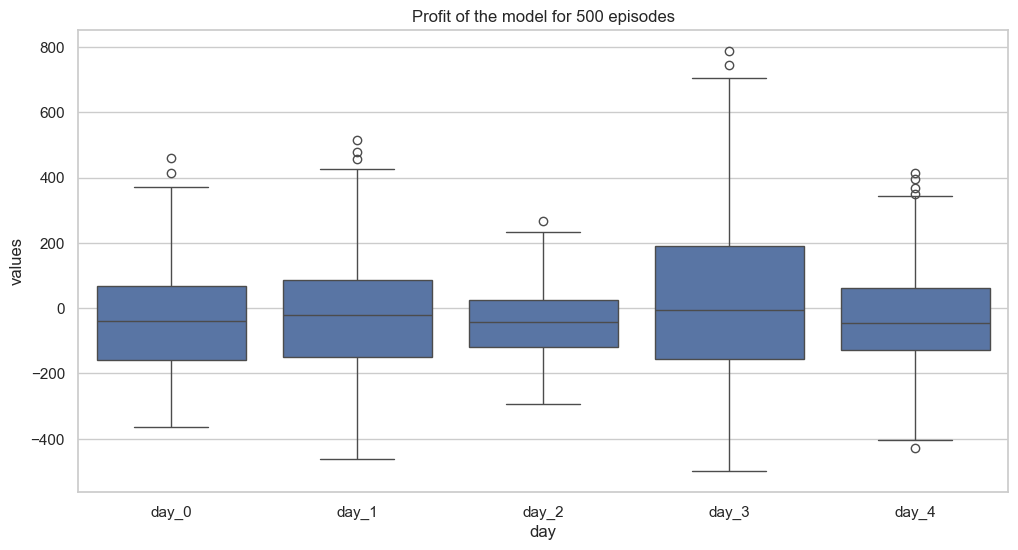

In [99]:

# plot the timesteps_test_df results with the index on the x axis and the values for the columns as the y axis and the column names as the color of the dots
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6)) 
sns.boxplot(x='day', y='values', data=timesteps_test_df_long)
plt.title(f'Profit of the model for {num_episodes} episodes')
plt.show()


In [11]:
data_path = 'C:/Users/WilliamFetzner/Documents/Trading/gym_mtsim_forked/gym_mtsim/data/symbols_forex_1hr_1_1_24_4_25_24 copy.pkl'
new_data_path = data_path.replace('copy', 'validation')

In [14]:
# with open(data_path, 'rb') as f:
#     symbols = pickle.load(f)
# current_data = symbols[1]['EURUSD']
# current_data.index = pd.to_datetime(current_data.index)
# current_data_validation_index = current_data[env_validation_2.time_points[0]:env_validation_2.time_points[-1]]
# symbols[1]['EURUSD'] = current_data_validation_index
# new_data_path = data_path.replace('copy', 'validation')
# with open(new_data_path , 'wb') as f:
#     pickle.dump(symbols, f)